# Common

In [1]:
import numpy as np
import json
import sys
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
rc('font', size=18)
from skimage import measure

# with open('Zalesak2D/Benchmark/setup.json') as f:
#     data = json.load(f)

# input_path  = "inputs/"
# case_list   = data["exec_list"]

In [2]:
def velocity_rv(x,y,t,T):
    v = - np.cos(4.0*np.pi*x) * np.cos(4.0*np.pi*y) * np.cos(np.pi*t/T)
    u = - np.sin(4.0*np.pi*x) * np.sin(4.0*np.pi*y) * np.cos(np.pi*t/T)
    return u,v

def velocity_sv(x,y,t,T):
    v = - 2*np.sin(np.pi*x) * np.cos(np.pi*x) * np.sin(np.pi*y) * np.sin(np.pi*y) * np.cos(np.pi*t/T)
    u = 2*np.sin(np.pi*x) * np.sin(np.pi*x) * np.sin(np.pi*y) * np.cos(np.pi*y) * np.cos(np.pi*t/T)
    return u,v

def rk2_rv(x,y,t,T,dt):
    u1, v1 = velocity_rv(x,y,t,T)
    x1 = x +  u1 * dt 
    y1 = y +  v1 * dt 
    u2, v2 = velocity_rv(x1,y1,t+dt,T)
    x2 = x + (u1 + u2) * dt / 2.0 
    y2 = y + (v1 + v2) * dt / 2.0 
    return x2, y2

def rk2_sv(x,y,t,T,dt):
    u1, v1 = velocity_sv(x,y,t,T)
    x1 = x +  u1 * dt 
    y1 = y +  v1 * dt 
    u2, v2 = velocity_sv(x1,y1,t+dt,T)
    x2 = x + (u1 + u2) * dt / 2.0 
    y2 = y + (v1 + v2) * dt / 2.0 
    return x2, y2

def exact_sv(T,tT):
    theta=np.arange(0,2*np.pi+2*np.pi/1000,2*np.pi/1000)
    x,y=np.cos(theta)*0.15,np.sin(theta) *0.15
    y=y+0.75
    x=x+0.5
    dt = 0.001
    t = 0.0
    nt = int(tT*T/dt)
    print(nt)
    for i in range(nt):
        x,y = rk2_sv(x,y,t,T,dt)
        t = t + dt
    return x,y
        
def exact_rv(T,tT):
    theta=np.arange(0,2*np.pi+2*np.pi/1000,2*np.pi/1000)
    x,y=np.cos(theta)*0.15,np.sin(theta) *0.15
#     y=y+0.75
#     x=x+0.5
    dt = 0.001
    t = 0.0
    nt = int(tT*T/dt)
    for i in range(nt):
        x,y = rk2_rv(x,y,t,T,dt)
        t = t + dt
    return x,y

In [3]:
def get_contours(test,methods,reso,cfl,frame,cmaps,xy_lo):
    css = {}
    arraydic = {}
    x = np.arange(int(reso))/float(reso) + 0.5 /float(reso) 
    y = np.arange(int(reso))/float(reso) + 0.5 /float(reso) 
    x = x + xy_lo[0]
    y = y + xy_lo[0]
    X,Y = np.meshgrid(x,y)
    i = 0
    for me in methods:
        h5f = test+'/cfl_'+str(cfl)+'/'+str(reso)+'/'+me+'/output.h5'
        f = h5py.File(h5f,'r')
#         print(h5f)
#         print(f['phi'].keys())
        dats = {}
        dat = np.array(f['phi'][frame][0,:,:])
#         dat = np.transpose(dat)
        cs = plt.contour(X,Y,dat,levels=[0.5])
        f.close()
        arraydic.update({me:dat})
        css.update({me:cs})
        plt.ioff()
        i+=1
    return arraydic, css

def plot_contour1(ax,cs,lab,cm):
    nc = len(cs.collections[0].get_paths())
#     print(nc)
    for i in range(nc):
        p = cs.collections[0].get_paths()[i]
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        if i==0:
            ax.plot(x,y,color=cm,label=lab)
        else:
            ax.plot(x,y,color=cm)
    return ax

def plot_contour2(ax,array_dic,cm):
    x = np.arange(int(reso))/float(reso)
    y = np.arange(int(reso))/float(reso)
    i=0
    for item in array_dic:
        ax.contour(x,y,array_dic[item]['data'],levels=[0.5],colors=cm)
        i+=1
    return ax

# Single Vortex

In [4]:
test = 'SingleVortex2D'
methods = ["EI","LE","LEEI2D","EILE2D","WY"]
cmaps = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
reso=64
cfl=0.1
T = 6
u=1

## N=64, CFL=0.05

3000
0


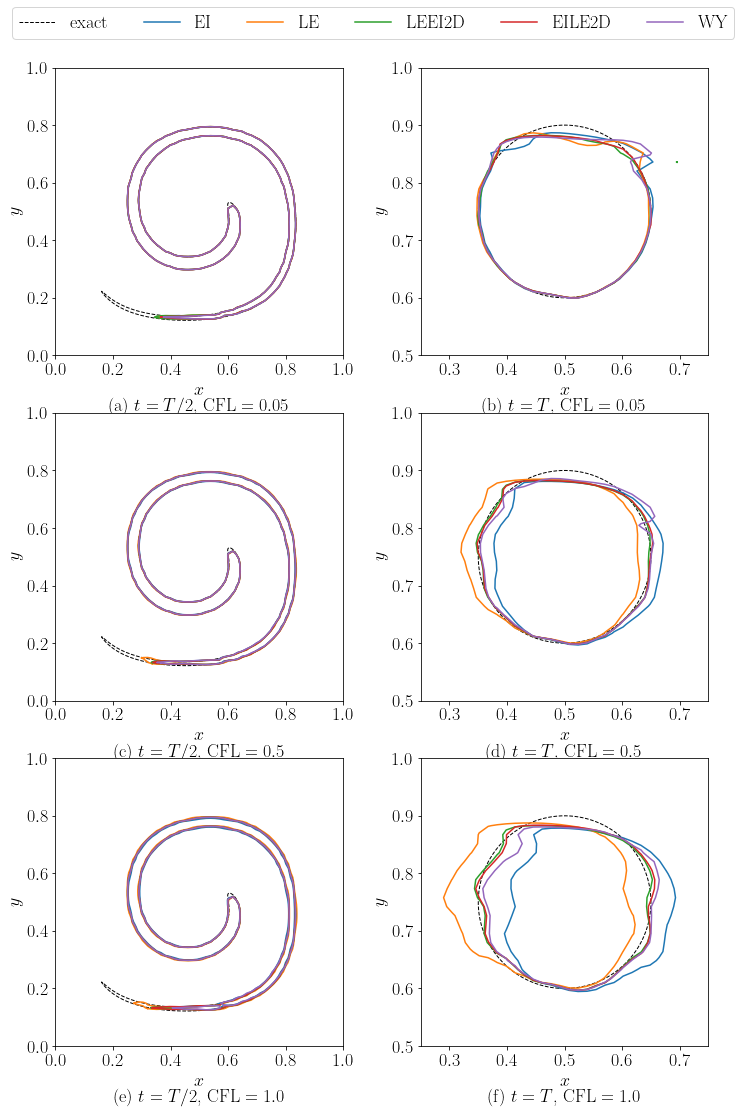

In [8]:
xy_lo = [0,0]
x1,y1=exact_sv(6,0.5)
x2,y2=exact_sv(6,0)
cfls = [0.05,0.5,1.0]
arraydics1 = []
ccs1 = []
arraydics2 = []
ccs2= []

text1 = [r'(a) $t=T/2$, $\rm{CFL}=0.05$',
         r'(c) $t=T/2$, $\rm{CFL}=0.5$',
         r'(e) $t=T/2$, $\rm{CFL}=1.0$']
text2 = [r'(b) $t=T$, $\rm{CFL}=0.05$',
         r'(d) $t=T$, $\rm{CFL}=0.5$',
         r'(f) $t=T$, $\rm{CFL}=1.0$']

for cfl in cfls:
    total_step = int(T*reso/cfl*2)
    frame1 = int(0.5*u*total_step)
    frame2 = int(0*u*total_step)
    xy_lo = [0,0]
    arraydic1, cc1 = get_contours(test,methods,reso,cfl,str(frame1),cmaps,xy_lo)
    arraydic2, cc2 = get_contours(test,methods,reso,cfl,'.000000',cmaps,xy_lo)
    arraydics1.append(arraydic1)
    arraydics2.append(arraydic2)
    ccs1.append(cc1)
    ccs2.append(cc2)
plt.close()
        
fig_seg=plt.figure(figsize=[12,18])
ax_segs = fig_seg.subplots(nrows=3, ncols=2)
resos = [32,64]
cfls  = [0.05,0.5,1.0]
ii=0
# nn=0
for cfl in cfls:
    i=0
    ax_segs[ii,0].plot(x1,y1,'k--',linewidth=1,label='exact')
    ax_segs[ii,1].plot(x2,y2,'k--',linewidth=1,label='exact')
    for item in methods:
        plot_contour1(ax_segs[ii,0],ccs1[ii][item],methods[i],cmaps[i])
        plot_contour1(ax_segs[ii,1],ccs2[ii][item],methods[i],cmaps[i])
        i+=1
    ax_segs[ii,0].set_aspect('equal')
    ax_segs[ii,0].set_xlim(0,1)
    ax_segs[ii,0].set_ylim(0,1)
    ax_segs[ii,0].set_xlabel(r'$x$')
    ax_segs[ii,0].set_ylabel(r'$y$')
    ax_segs[ii,0].text(0.5,-0.18, text1[ii],
                       horizontalalignment='center',
                       verticalalignment='center')
    ax_segs[ii,1].set_aspect('equal')
    ax_segs[ii,1].set_xlim(0.25,0.75)
    ax_segs[ii,1].set_ylim(0.5,1.0)  
    ax_segs[ii,1].set_xlabel(r'$x$')
    ax_segs[ii,1].set_ylabel(r'$y$')
    ax_segs[ii,1].text(0.5,0.41, text2[ii],
                       horizontalalignment='center',
                       verticalalignment='center')
    ii+=1
ax_segs[0,0].legend(ncol=6,loc=[-0.15,1.1])
fig_seg.savefig('plots/sv2dcompare.pdf',box_inches='tight', pad_inches = 0)

# Reverse Vortex

In [13]:
test = 'ReverseVortex2D'
methods = ["EI","LE","LEEI2D","EILE2D","WY"]
cmaps = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
reso=64
cfl=0.1
T = 2
u=1

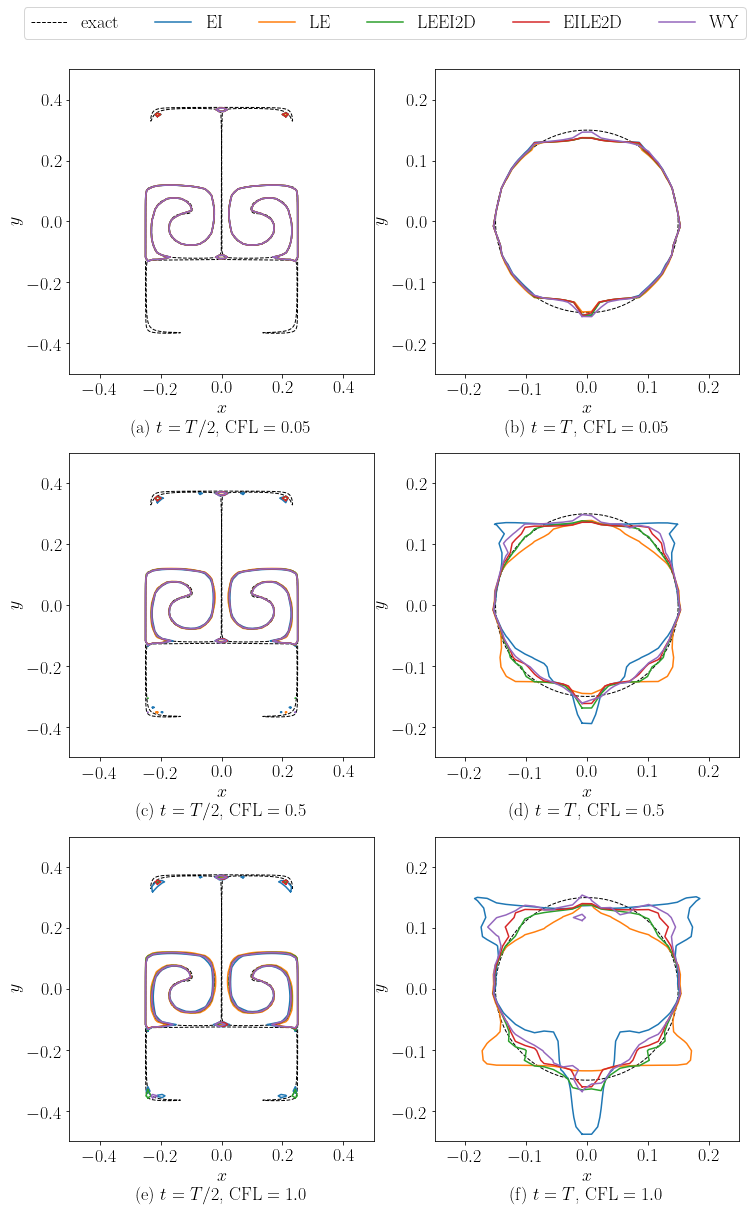

In [14]:
xy_lo = [-0.5,-0.5]
x1,y1=exact_rv(2,0.5)
x2,y2=exact_rv(2,0)
cfls = [0.05,0.5,1.0]
arraydics1 = []
ccs1 = []
arraydics2 = []
ccs2= []

text1 = [r'(a) $t=T/2$, $\rm{CFL}=0.05$',
         r'(c) $t=T/2$, $\rm{CFL}=0.5$',
         r'(e) $t=T/2$, $\rm{CFL}=1.0$']
text2 = [r'(b) $t=T$, $\rm{CFL}=0.05$',
         r'(d) $t=T$, $\rm{CFL}=0.5$',
         r'(f) $t=T$, $\rm{CFL}=1.0$']

for cfl in cfls:
    total_step = int(T*reso/cfl)
    frame1 = int(0.5*u*total_step)
    frame2 = int(0*u*total_step)
    arraydic1, cc1 = get_contours(test,methods,reso,cfl,str(frame1),cmaps,xy_lo)
    arraydic2, cc2 = get_contours(test,methods,reso,cfl,'.000000',cmaps,xy_lo)
    arraydics1.append(arraydic1)
    arraydics2.append(arraydic2)
    ccs1.append(cc1)
    ccs2.append(cc2)
plt.close()
        
fig_seg=plt.figure(figsize=[12,20])
ax_segs = fig_seg.subplots(nrows=3, ncols=2)
resos = [32,64]
cfls  = [0.05,0.5,1.0]
ii=0
# nn=0
for cfl in cfls:
    i=0
    ax_segs[ii,0].plot(x1,y1,'k--',linewidth=1,label='exact')
    ax_segs[ii,1].plot(x2,y2,'k--',linewidth=1,label='exact')
    for item in methods:
        plot_contour1(ax_segs[ii,0],ccs1[ii][item],methods[i],cmaps[i])
        plot_contour1(ax_segs[ii,1],ccs2[ii][item],methods[i],cmaps[i])
        i+=1
    ax_segs[ii,0].set_aspect('equal')
    ax_segs[ii,0].set_xlim(-0.5,0.5)
    ax_segs[ii,0].set_ylim(-0.5,0.5)
    ax_segs[ii,0].set_xlabel(r'$x$')
    ax_segs[ii,0].set_ylabel(r'$y$')
    ax_segs[ii,0].text(0,-0.68, text1[ii],
                       horizontalalignment='center',
                       verticalalignment='center')
    ax_segs[ii,1].set_aspect('equal')
    ax_segs[ii,1].set_xlim(-0.25,0.25)
    ax_segs[ii,1].set_ylim(-0.25,0.25)  
    ax_segs[ii,1].set_xlabel(r'$x$')
    ax_segs[ii,1].set_ylabel(r'$y$')
    ax_segs[ii,1].text(0,-0.34, text2[ii],
                       horizontalalignment='center',
                       verticalalignment='center')
    ii+=1
ax_segs[0,0].legend(ncol=6,loc=[-0.15,1.1])
fig_seg.savefig('plots/rv2dcompare.pdf',box_inches='tight', pad_inches = 0)